In [6]:
"""
Neal, D.(1999). the complexity of job mobility among young men, journal of
labor economics, 17(2), 237-261
"""

from textwrap import dedent
import numpy as np
from quantecon.distributions import BetaBinomial

class CareerWorkerProblem(object):
    
    """
    an instance of the class is an object with data on a particular problem
    of this type, including probabilities, discount factor and sample space for
    the variables.
    
    parameters
    ------
    beta: scalar(float), optional(default=5.0)
        Discount factor
    B: scalar(float), optional(default=0.95)
        Upper bound of for both epsilon and theta
    N: scalar(int), optional(default=50)
        Number of possible realizations for both epsilon and theta
    F_a: scalar(int or float), optional(default=1)
        Parameter 'a' from the career distribution
    F_b: scalar(int or float), optional(default=1)
        Parameter 'b' from the career distribution
    G_a: scalar(int or float), optional(default=1)
        Parameter 'a' from the job distribution
    G_b: scalar(int or float), optional(default=1)
        Parameter 'b' from the job distribution 
    
    attributes
    ------
    beta, B, N: see parameters
    theta: array_like(float, ndim=1)
        A grid of values from 0 to B
    epsilon: array_like(float, ndim=1)
        A grid of values from 0 to B
    F_probs: array_like(float, ndim=1)
        The probabilities of different values for F
    G_probs: array_like(float, ndim=1)
        The probabilities of different values for G
    F_mean: scalar(float)
        The mean of the distribution for F
    G_mean: scalar(float)
        The mean of the distribution for G
        
    """
    
    def __init__(self, B=5.0, beta=0.95, N=50, F_a=1, F_b=1, G_a=1,
                G_b=1):
        self.beta, self.N, self.B=beta, N, B
        self.theta=np.linspace(0,B,N) #set of theta values
        self.epsilon=np.linspace(0,B,N) #set of epsilon values
        self.F_probs=BetaBinomial(N-1, F_a, F_b).pdf()
        self.G_probs=BetaBinomial(N-1, G_a, G_b).pdf()
        self.F_mean=np.sum(self.theta*self.F_probs)
        self.G_mean=np.sum(self.epsilon*self.G_probs)
        
        # store these parameters for str and repr methods
        self._F_a, self._F_b=F_a, F_b
        self._G_a, self._G_b=G_a, G_b
        
    def __repr__(self):
        m="CareerWorkerProblem(beta={b:g}, B={B:g}, N={n:g}, F_a={fa:g},"
        m+="F_b={fb:g}, G_a={ga:g}, G_b={gb:g})"
        return m.format(b=self.beta, B=self.B, n=self.N, fa=self._F_a,
                       fb=self._F_b, ga=self._G_a, gb=self._G_b)
    
    def __str__(self):
        m="""\
        CareerWorkerProblem(Neal, 1999)
            -beta(discount factor)                          :{b:g}
            -B(upper bound for epsilon and theta): {B:g}
            -N(number of realizations of epsilon and theta):{n:g}
            -F_a(parameter a from career distribution)        :{fa:g}
            -F_b(parameter b from career distribution)        :{fb:g}
            -G_a(parameter a from job distribution)            :{ga:g}
            -G_b(parameter b from job distribution)            :{gb:g}
            """
        return dedent(m.format(b=self.beta, B=self.B, n=self.N, fa=self._F_a,
                              fb=self._F_b, ga=self._G_a, gb=self._G_b))
    
    def bellman_operator(self, v):
        """
        The Bellman operator for the career/job choice model of Neal.
        
        parameters
        ------
        v: array_like(float)
            A 2D Numpy array representing the value function
            Intepretation::math: v[i,j]=v(\theta_i, \epsilon_j)
            
        returns
        ------
        new_v: array_like(float)
            The updated value function Tv as an array of shape v.shape
        
        """
        new_v=np.empty(v.shape)
        for i in range(self.N):
            for j in range(self.N):
                #stay put
                v1=self.theta[i]+self.epsilon[j]+self.beta*v[i,j]
                
                #new job
                v2=(self.theta[i]+self.G_mean+self.beta*
                    np.dot(v[i,:], self.G_probs))
                
                #new life
                v3=(self.G_mean+self.F_mean+self.beta*
                   np.dot(self.F_probs, np.dot(v, self.G_probs)))
                new_v[i,j]=max(v1, v2, v3)
                
        return new_v
    
    def get_greedy(self, v):
        """
        compute optimal actions taking v as the value function
        
        parameters
        ------
        v: array_like(float)
            A 2D Numpy array representing the value function
            Interpretation:: math: v[i,j]=v(\theta_i, \epsilon_j)
            
        returns
        ------
        policy: array_like(float)
            A 2D Numpy array, where policy[i,j] is the optimal action
            at: math:(\theta_i, \epsilon_j)
            
            The optimal action is represented as an integer in the set
            1, 2, 3, where 1='stay put', 2='new job', and 3='new life'
            
        """
        
        policy=np.empty(v.shape, dtype=int)
        for i in range(self.N):
            for j in range(self.N):
                v1 = self.theta[i] + self.epsilon[j] + self.beta * v[i, j]
                
                v2 = (self.theta[i] + self.G_mean + self.beta *
                      np.dot(v[i, :], self.G_probs))

                v3 = (self.G_mean + self.F_mean + self.beta *
                      np.dot(self.F_probs, np.dot(v, self.G_probs)))
                if v1>max(v2, v3):
                    action=1
                elif v2>max(v1, v3):
                    action=2
                else:
                    action=3
                policy[i,j]=action
        
        return policy

In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from quantecon import DiscreteRV, compute_fixed_point

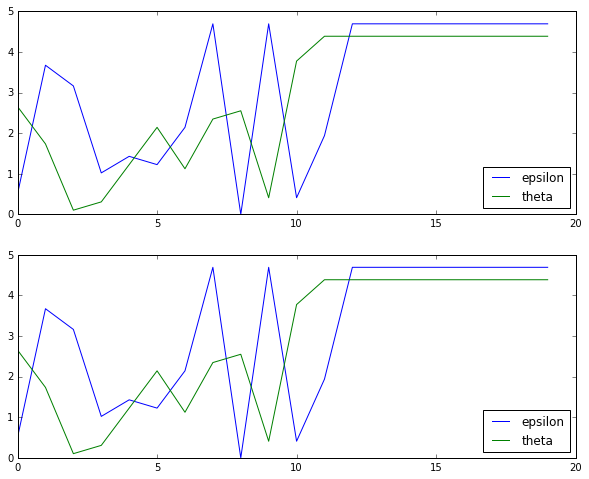

In [19]:
wp=CareerWorkerProblem()
v_int=np.ones((wp.N, wp.N))*100
v=compute_fixed_point(wp.bellman_operator, v_int, verbose=False)
optimal_policy=wp.get_greedy(v)
F=DiscreteRV(wp.F_probs)
G=DiscreteRV(wp.G_probs)

def gen_path(T=20):
    i=j=0
    theta_index=[]
    epsilon_index=[]
    for t in range(T):
        if optimal_policy[i,j]==1: #stay put
            pass
        elif optimal_policy[i,j]==2: #new job
            j=int(G.draw())
        else: #new life
            i,j=int(F.draw()), int(G.draw())
        theta_index.append(i)
        epsilon_index.append(j)
    return wp.theta[theta_index], wp.epsilon[epsilon_index]

theta_path, epsilon_path=gen_path()

fig, axes=plt.subplots(2, 1, figsize=(10,8))
for ax in axes:
    ax.plot(epsilon_path, label='epsilon')
    ax.plot(theta_path, label='theta')
    ax.legend(loc='lower right')

plt.show()

In [20]:
def gen_first_passage_time():
    t=0
    i=j=0
    while 1:
        if optimal_policy[i,j]==1: #stay put
            return t
        elif optimal_policy[i,j]==2: #new job
            j=int(G.draw())
        else: #new life
            i, j=int(F.draw()), int(G.draw())
        t+=1

M=25000 #number of samples
samples=np.empty(M)
for i in range(M):
    samples[i]=gen_first_passage_time()
print(np.median(samples))

7.0


In [21]:
wp=CareerWorkerProblem(beta=0.99)
v_int=np.ones((wp.N, wp.N))*100
v=compute_fixed_point(wp.bellman_operator, v_int, verbose=False)
optimal_policy=wp.get_greedy(v)
F=DiscreteRV(wp.F_probs)
G=DiscreteRV(wp.G_probs)
def gen_first_passage_time():
    t=0
    i=j=0
    while 1:
        if optimal_policy[i,j]==1: #stay put
            return t
        elif optimal_policy[i,j]==2: #new job
            j=int(G.draw())
        else: #new life
            i, j=int(F.draw()), int(G.draw())
        t+=1

M=25000 #number of samples
samples=np.empty(M)
for i in range(M):
    samples[i]=gen_first_passage_time()
print(np.median(samples))

9.0


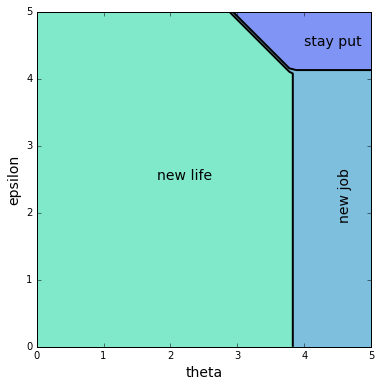

In [22]:
from matplotlib import cm

wp=CareerWorkerProblem()
v_int=np.ones((wp.N, wp.N))*100
v=compute_fixed_point(wp.bellman_operator, v_int, verbose=False)
optimal_policy=wp.get_greedy(v)

fig, ax=plt.subplots(figsize=(6,6))
tg, eg=np.meshgrid(wp.theta, wp.epsilon)
lvls=(0.5,1.5,2.5,3.5)
ax.contourf(tg, eg, optimal_policy.T, levels=lvls, cmap=cm.winter, alpha=0.5)
ax.contour(tg, eg, optimal_policy.T, colors='k', levels=lvls, linewidths=2)
ax.set_xlabel('theta', fontsize=14)
ax.set_ylabel('epsilon', fontsize=14)
ax.text(1.8, 2.5, 'new life', fontsize=14)
ax.text(4.5, 2.5, 'new job', fontsize=14, rotation='vertical')
ax.text(4.0, 4.5, 'stay put', fontsize=14)

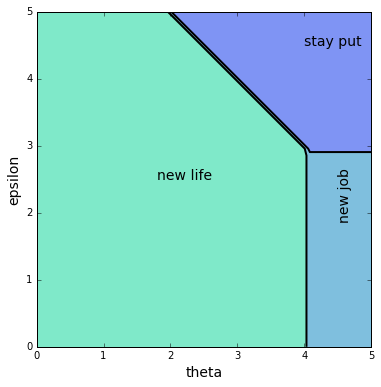

In [23]:
wp=CareerWorkerProblem(G_a=100, G_b=100)
v_int=np.ones((wp.N, wp.N))*100
v=compute_fixed_point(wp.bellman_operator, v_int, verbose=False)
optimal_policy=wp.get_greedy(v)

fig, ax=plt.subplots(figsize=(6,6))
tg, eg=np.meshgrid(wp.theta, wp.epsilon)
lvls=(0.5,1.5,2.5,3.5)
ax.contourf(tg, eg, optimal_policy.T, levels=lvls, cmap=cm.winter, alpha=0.5)
ax.contour(tg, eg, optimal_policy.T, colors='k', levels=lvls, linewidths=2)
ax.set_xlabel('theta', fontsize=14)
ax.set_ylabel('epsilon', fontsize=14)
ax.text(1.8, 2.5, 'new life', fontsize=14)
ax.text(4.5, 2.5, 'new job', fontsize=14, rotation='vertical')
ax.text(4.0, 4.5, 'stay put', fontsize=14)